In [2]:
!pip install fastai==2.7.9
!pip install fastkaggle==0.0.7
!pip install fasterai==0.1.11
!pip install ipython-autotime==0.3.1
!pip install torch==1.12.1
%load_ext autotime

  Using cached fastai-2.7.9-py3-none-any.whl (225 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 41.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.12
    Uninstalling fastai-2.7.12:
      Successfully uninstalled fastai-2.7.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 require

In [3]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from fastai.fp16_utils import *

from fasterai.sparse.all import *
from fasterai.core.criteria import *
from fasterai.regularize.all import *

from fastkaggle import *

import torch
import torch.nn as nn
import torch.nn.functional as F


set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


time: 4.21 s (started: 2023-05-20 11:53:07 +00:00)


In [4]:
@patch
def custom_plot_losses(self: Recorder, skip_start=5, with_valid=True):
    fig2 = plt.figure("Figure 2")

    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_loss') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train loss')
    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_loss') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid loss')
        plt.legend()

    
@patch
def custom_plot_values(self: Recorder, skip_start=5, with_valid=True):
    fig3 = plt.figure("Figure 3")
    
    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_accuracy') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train accuracy')

    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_accuracy') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid accuracy')
        plt.legend()

time: 2.42 ms (started: 2023-05-20 11:53:12 +00:00)


In [5]:
comp = 'paddy-diseases/paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 18.8 s (started: 2023-05-20 11:53:12 +00:00)


In [6]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32//2)

time: 9.92 s (started: 2023-05-20 11:53:30 +00:00)


In [7]:
sp_cb=[
      GradientAccumulation(32), 
      SparsifyCallback(sparsity=25, 
                         granularity='filter', 
                         context='local', 
                         criteria=large_final, 
                         schedule=one_cycle),

]

time: 915 µs (started: 2023-05-20 11:53:40 +00:00)


In [8]:
model = vgg16_bn(num_classes=10)


time: 3.53 s (started: 2023-05-20 11:53:40 +00:00)


In [9]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy,
                         error_rate,
                        ]).to_fp16()
learn.unfreeze()
learn.recorder.train_metrics = True
learn.path = Path("/kaggle/working/")

time: 10.5 ms (started: 2023-05-20 11:53:44 +00:00)


Pruning of filter until a sparsity of [25]%
Saving Weights at epoch 0


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,2.234109,0.173237,0.826763,2.067576,0.280288,0.719712,01:38
1,2.159685,0.221474,0.778526,2.018880,0.290865,0.709135,01:22
2,2.060769,0.237821,0.762179,1.987126,0.297115,0.702885,01:43
3,2.067913,0.257532,0.742468,1.943490,0.325962,0.674038,01:42
4,2.020909,0.278526,0.721474,1.934226,0.319231,0.680769,01:45
5,2.000083,0.282212,0.717788,1.851287,0.361538,0.638462,01:47
6,1.925655,0.311058,0.688942,1.798944,0.382692,0.617308,01:45
7,1.899225,0.322596,0.677404,1.762318,0.400000,0.600000,01:26
8,1.869325,0.341186,0.658814,1.678449,0.420192,0.579808,01:26
9,1.822772,0.366987,0.633013,1.642060,0.442788,0.557212,01:46


Sparsity at the end of epoch 0: [0.07]%
Sparsity at the end of epoch 1: [0.08]%
Sparsity at the end of epoch 2: [0.09]%
Sparsity at the end of epoch 3: [0.11]%
Sparsity at the end of epoch 4: [0.12]%
Sparsity at the end of epoch 5: [0.14]%
Sparsity at the end of epoch 6: [0.16]%
Sparsity at the end of epoch 7: [0.19]%
Sparsity at the end of epoch 8: [0.22]%
Sparsity at the end of epoch 9: [0.25]%
Sparsity at the end of epoch 10: [0.29]%
Sparsity at the end of epoch 11: [0.33]%
Sparsity at the end of epoch 12: [0.38]%
Sparsity at the end of epoch 13: [0.43]%
Sparsity at the end of epoch 14: [0.5]%
Sparsity at the end of epoch 15: [0.57]%
Sparsity at the end of epoch 16: [0.65]%
Sparsity at the end of epoch 17: [0.75]%
Sparsity at the end of epoch 18: [0.86]%
Sparsity at the end of epoch 19: [0.98]%
Sparsity at the end of epoch 20: [1.12]%
Sparsity at the end of epoch 21: [1.28]%
Sparsity at the end of epoch 22: [1.46]%
Sparsity at the end of epoch 23: [1.67]%
Sparsity at the end of epoc

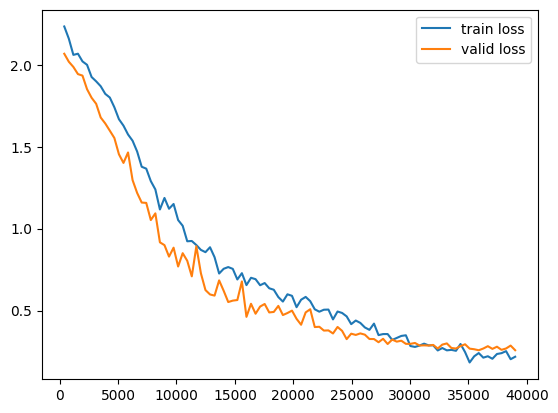

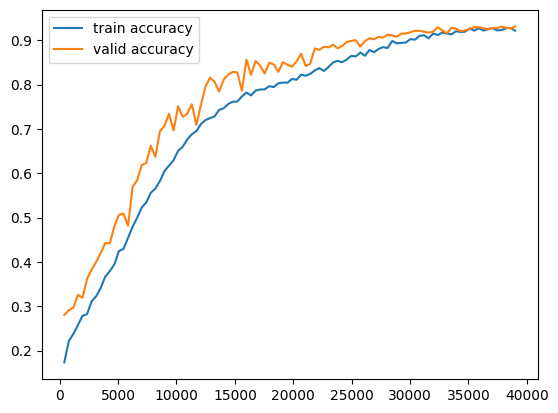

time: 2h 10min 46s (started: 2023-05-20 11:53:44 +00:00)


In [10]:
learn.fit_one_cycle(100, 3e-5, cbs=sp_cb)
                    
learn.recorder.custom_plot_losses()
learn.recorder.custom_plot_values()

In [11]:
learn.export(Path("/kaggle/working/VGG16_bn_fp16_accum2_sparsity25.pkl"))

time: 2.29 s (started: 2023-05-20 14:04:30 +00:00)


In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

time: 541 µs (started: 2023-05-20 14:04:32 +00:00)


In [13]:
count_parameters(learn.model)


134309962

time: 12.7 ms (started: 2023-05-20 14:04:32 +00:00)


In [14]:
pruner = Pruner()
pruned_model = pruner.prune_model(learn.model)

time: 99 ms (started: 2023-05-20 14:04:32 +00:00)


In [15]:
pruned_learn = Learner(dls, pruned_model.cuda(), metrics=accuracy)

time: 4.5 ms (started: 2023-05-20 14:04:32 +00:00)


In [16]:
pruned_learn.validate()

(#2) [0.2584651708602905,0.9307692050933838]

time: 15.3 s (started: 2023-05-20 14:04:32 +00:00)


In [17]:
count_parameters(pruned_learn)

102181178

time: 4.84 ms (started: 2023-05-20 14:04:48 +00:00)


In [18]:
pruned_learn.export(Path("/kaggle/working/VGG16_bn_fp16_accum2_sparsity25_pruned.pkl"))

time: 1.74 s (started: 2023-05-20 14:04:48 +00:00)
